In [1]:
import requests
from bs4 import BeautifulSoup
import time

In [2]:
def fetch(query = None, auto_make_model = None, min_auto_year = None, max_auto_year = None, s=0):
    search_params = {key: val for key, val in locals().items() if val is not None}
    if not search_params: 
        raise ValueError("No valid keywords")
        
    base = "http://boston.craigslist.org/search/cto"
    resp = requests.get(base, params=search_params, timeout=3)
    resp.raise_for_status()
    return resp.content, resp.encoding

In [3]:
def parse(html, encoding='utf-8'):
    parsed = BeautifulSoup(html, 'lxml', from_encoding=encoding)
    return parsed

In [4]:
def extract_listings(parsed):
    listings = parsed.find_all('p', class_='result-info')
    extracted = []
    for listing in listings:
        title = listing.find('a', class_='result-title hdrlnk')
        price = listing.find('span', class_='result-price')
        try:
            price_string = price.string.strip()
        except AttributeError:
            price_string = ''
        location = listing.find('span', class_='result-hood')
        try:
            loc_string = location.string.strip()[1:-1].split()[0]
        except AttributeError:
            loc_string = ''
        this_listing = {
            'link': title.attrs['href'],
            'description': title.string.strip(),
            'price': price_string,
            'location': loc_string
        }
        extracted.append(this_listing)
    return extracted

In [5]:
import pandas as pd
import numpy as np

In [6]:
import re

def get_mileage(description):
    description = description.lower().split('k miles')
    if len(description) == 1:
        description = description[0].split('000 miles')
        if len(description) == 1:
            try:
                description = re.search('(\d{1,3})k', description[0]).groups()
            except:
                return np.nan
    mileage = re.sub('[^0-9]', '', description[0].split()[-1])
    try:
        mileage = int(mileage) * 1000
        return mileage
    except:
        return np.nan

In [7]:
def get_year(description):
    description = re.split('(20[0-9][0-9])', description)
    if len(description) == 1:
        description = re.split('(19[0-9][0-9])', description[0])
    if len(description) == 1:
        description = re.split('([0-1][0-9])', description[0])
    if len(description) == 1:
        return np.nan
    if len(description[1]) == 4: 
        year = description[1]
    elif int(description[1]) > 17: 
        year = '19' + description[1]
    else: 
        year = '20' + description[1]
    try:
        return int(year) if int(year) <= 2017 else np.nan
    except:
        return np.nan

In [8]:
def get_standard_location(location):
    """
    Use first 5 characters of location in order to group. Gets rid of much of the weird stuff
    """
    if len(location) < 5:
        return re.sub('[^a-z]', '', location.lower())
    else:
        return re.sub('[^a-z]', '', location[:5].lower())

In [9]:
def get_price(price):
    try:
        return int(price[1:]) if int(price[1:]) > 100 else np.nan
    except:
        return np.nan

In [64]:
def scrape_all(search_params={}):
    listings = []
    base = "http://boston.craigslist.org/search/cto"
    for i in range(0, 1000, 100):
        search_params['s'] = i
        resp = requests.get(base, params=search_params, timeout=3)
        resp.raise_for_status()
        with open('sizing.txt', 'a+') as f:
            f.write(resp.content)
        f.close()
        car_results = resp.content, resp.encoding
        doc = parse(car_results[0])
        listings.extend(extract_listings(doc))
        time.sleep(2)
    
    df = pd.DataFrame(data=listings)
    
    df['mileage'] = df.apply(lambda row: get_mileage(row['description']), axis=1)
    df['price'] = df.apply(lambda row: get_price(row['price']), axis=1)
    df['region'] = df['link'].str[1:5]
    df['year'] = df.apply(lambda row: get_year(row['description']), axis=1)
    df['std_location'] = df.apply(lambda row: re.sub('[^a-z]', '', get_standard_location(row['location'])), axis=1)
    df.set_index('link', inplace=True)
    df = df.drop_duplicates()
    
    return df

In [65]:
all_car_info = scrape_all()
print len(all_car_info)
all_car_info = all_car_info.append(scrape_all(search_params={'searchNearby': 1}))
print len(all_car_info)
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

955
1935
993


In [66]:
all_car_info = all_car_info.append(scrape_all(search_params={'sort': 'pricedsc'}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

1835


In [67]:
all_car_info = all_car_info.append(scrape_all(search_params={'sort': 'priceasc'}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

2753


In [68]:
all_car_info = all_car_info.append(scrape_all(search_params={'auto_transmission': 1}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

3432


In [69]:
all_car_info.head()

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/gbs/cto/6038170033.html,2001 FORD F250 4WD VERY CLEAN TRUCK,BOSTON,2010.0,NaN,gbs/,2001.0,bosto
/gbs/cto/6038290733.html,2005 Honda Accord miles 118000,Burlington,3500.0,NaN,gbs/,2005.0,burli
/sob/cto/6028105979.html,1995 Jeep Grand Cherokee,Kingston,1500.0,NaN,sob/,1995.0,kings
/sob/cto/6035275913.html,2004 VW Jetta GLS,Randolph,1500.0,NaN,sob/,2004.0,rando
/nos/cto/6038309143.html,98 Volvo V70 XC wagon.. All wheel drive.. Runs...,90mins,1100.0,NaN,nos/,NaN,min


In [18]:
import pandas_profiling
pandas_profiling.ProfileReport(all_car_info)

Number of variables,8
Number of observations,1786
Total Missing (%),15.6%
Total size in memory,111.7 KiB
Average record size in memory,64.0 B
Numeric,3
Categorical,4
Date,0
Text (Unique),1
Rejected,0
Distinct count,1763


In [19]:
all_car_info.to_csv("all_car_info.csv", encoding='utf-8')

Methods of getting more (older) results:

-include nearby areas (searchNearby=1)

-sort by price (sort=pricedsc or sort=priceasc)

-manual transmission (auto_transmission=1)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("ticks")

(1950, 2020.9073466988507)

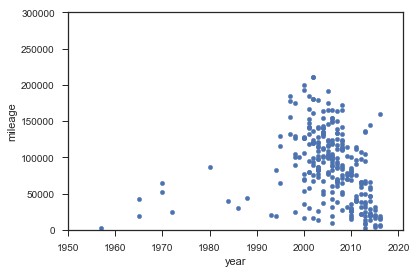

In [70]:
all_car_info.plot.scatter('year', 'mileage')
plt.ylim(0,3E5)
plt.xlim(1950,)

In [71]:
%store all_car_info

Stored 'all_car_info' (DataFrame)


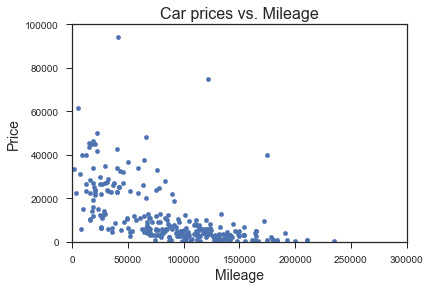

In [72]:
all_car_info.plot.scatter('mileage', 'price')
plt.xlim(0,3E5)
plt.xlabel('Mileage', fontdict={'fontsize': 14})
plt.ylim(0,1E5)
plt.ylabel('Price', fontdict={'fontsize': 14})
plt.title('Car prices vs. Mileage', fontdict={'fontsize': 16})

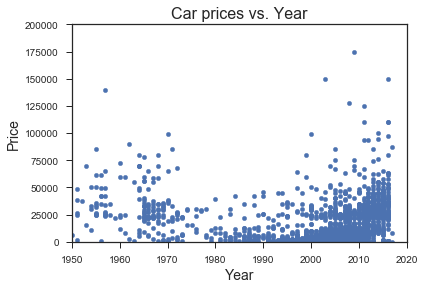

In [73]:
all_car_info.plot.scatter('year', 'price')
plt.ylim(0,2E5)
plt.ylabel('Price', fontdict={'fontsize': 14})
plt.xlim(1950,2020)
plt.xlabel('Year', fontdict={'fontsize': 14})
plt.title('Car prices vs. Year', fontdict={'fontsize': 16})

In [25]:
print all_car_info[all_car_info['price'] >= 150000]

                                                       description  \
link                                                                 
/nwb/cto/6015540237.html                 Ford Super Duty F-250 XLT   
/gbs/cto/6012694899.html                Wanted International Scout   
/sob/cto/5984590921.html             2004 ford f250 4x4 work truck   
/gbs/cto/6023740039.html  1936 Mercedes-Benz 540K Special Roadster   
/bmw/cto/6006712769.html                2015 mercedes sprinter van   
/nwb/cto/6012547859.html                    2014 mercedes sprinter   
/sob/cto/6037065614.html             2009 Chevy Silverado for sale   
/gbs/cto/6015290765.html                         Truck and trailer   
/sob/cto/6018476718.html                         2003 Saleen Cobra   

                            location      price   mileage region    year  \
link                                                                       
/nwb/cto/6015540237.html              9999999.0       NaN   nwb/     NaN   
/

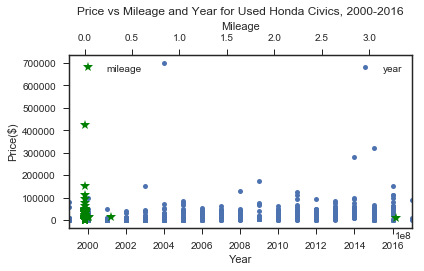

In [28]:
df = all_car_info
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Year')
ax1.set_ylabel('Price($)')
ax1.set_title('Price vs Mileage and Year for Used Honda Civics, 2000-2016', y= 1.2)
plt.plot(df['year'], df['price'], '.', ms=10, label='year')
ax1.set_xbound(lower=1999, upper=2017)
ax1.legend(loc='best')
ax2 = ax1.twiny()
ax2.set_xlabel('Mileage')
plt.plot(df['mileage'], df['price'], 'g*', ms=10, label='mileage')
ax2.legend(loc=2)
plt.tight_layout()
plt.savefig('price_year_mileage.pdf')

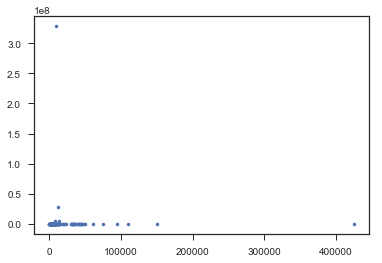

In [29]:
plt.plot(df['price'], df['mileage'], linestyle='', marker='.')

In [81]:
regions = all_car_info[all_car_info['std_location'] != ''].groupby('std_location').agg(['mean', 'count'])

In [82]:
regions = regions[regions['price','count'] >= 25]
regions = regions[regions['mileage','count'] >= 5]

In [89]:
regions =regions.drop('arlin')
regions.head()

price              mileage               year      
                     mean count           mean count         mean count
std_location                                                           
stone         3978.846154    26   99800.000000     5  2000.000000    23
malde         4570.283019    53  114866.666667    15  2002.803571    56
lowel         7052.632653    49  111285.714286     7  2000.585366    41
saugu         7491.307692    26   79166.666667     6  1999.384615    26
evere         9687.400000    25   83200.000000     5  2006.956522    23

In [90]:
#regions = regions.drop('price_mileage_ratio', axis=1)
%store regions

Stored 'regions' (DataFrame)


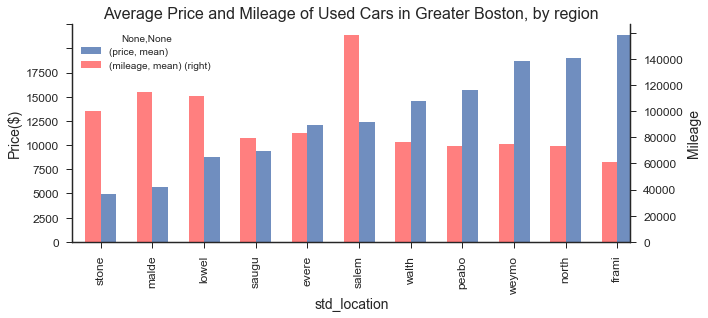

In [91]:
regions.sort_values(by=[('price', 'mean')], inplace=True)
ax = regions['price','mean'].plot.bar(position=0, width=0.3, alpha=0.8, legend=True)
ax.set_title('Average Price and Mileage of Used Cars in Greater Boston, by region', fontdict={'fontsize':16})
ax.set_xlabel('City/Town', fontdict={'fontsize':14})
ax.set_xticklabels(regions.index, fontdict={'fontsize':12})
ax.set_ylabel('Price($)', fontdict={'fontsize':14})
ax.set_yticklabels(range(0,20000,2500), fontdict={'fontsize':12})
ax = regions['mileage','mean'].plot.bar(secondary_y=True, color='red', position=1, width=0.3, alpha=0.5, legend=True)
ax.set_ylabel('Mileage', fontdict={'fontsize':14})
ax.set_yticklabels(range(0,160000,20000), fontdict={'fontsize':12})
sns.despine(top=True, right=False)
fig=ax.get_figure()
fig.set_size_inches(10,4)
fig.savefig('price_mileage_region.pdf', bbox_inches='tight')

In [43]:
from scipy.stats import linregress

In [44]:
print linregress(df['mileage'][~df['price'].isnull()].dropna(), df['price'][~df['mileage'].isnull()].dropna())
print linregress(df['year'][~df['price'].isnull()].dropna(), df['price'][~df['year'].isnull()].dropna())
print linregress(df['year'][~df['mileage'].isnull()].dropna(), df['mileage'][~df['year'].isnull()].dropna())

LinregressResult(slope=-2.352193275474573e-05, intercept=17054.759838350124, rvalue=-0.01595614063440428, pvalue=0.84581932657227321, stderr=0.00012075266434977453)
LinregressResult(slope=-241.43285412552288, intercept=501938.69259059645, rvalue=-0.12032176068243439, pvalue=1.4368605108296703e-05, stderr=55.43989246689727)
LinregressResult(slope=69372.004434804781, intercept=-136634191.35233921, rvalue=0.032854273834714467, pvalue=0.68098533877427658, stderr=168425.57098760354)


In [45]:
def draw_regional_fig(make, model, year):
    listings = []
    make_model = "{0} {1}".format(make,model)
    min_auto_year = int(year) - 2
    max_auto_year = int(year) + 2
    if max_auto_year > 2016:
        max_auto_year = 2016
    for i in range(0, 500, 100):
        car_results = fetch(auto_make_model=make_model, min_auto_year=min_auto_year, max_auto_year=max_auto_year, s=i)
        doc = parse(car_results[0])
        listings.extend(extract_listings(doc))
    
    df = pd.DataFrame(data=listings)
    if len(df) == 0: return "No results found, check your spelling"
    df['mileage'] = df.apply(lambda row: get_mileage(row['description']), axis=1)
    df['price'] = df.apply(lambda row: get_price(row['price']), axis=1)
    df['region'] = df['link'].str[1:5]
    df['year'] = df.apply(lambda row: get_year(row['description']), axis=1)
    
    regions = df.groupby('region').mean()
    regions = regions.append(pd.Series(data={'year': np.mean(df['year']), 'price': np.mean(df['price']), 'mileage': np.mean(df['mileage'])}, name='AVERAGE'))
    
    my_title = 'Average Price and Mileage of Used {0} {1}, {2}-{3}, by region, n={4}'.format(make, model, min_auto_year, max_auto_year, len(df))
    ax = regions['price'].plot.bar(position=0, width=0.3, alpha=0.5, legend=True, title=my_title)
    ax.set_ylabel('Price($)')
    ax = regions['mileage'].plot.bar(secondary_y=True, color='green', position=1, width=0.3, alpha=0.5, legend=True)
    ax.set_ylabel('Mileage')
    sns.despine(top=True, right=False)
    fig=ax.get_figure()
    
    return fig

In [46]:
focus_data = scrape_all(search_params={'auto_make_model': 'ford focus'})
print len(focus_data)
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'searchNearby': 1}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

128
256
128


In [47]:
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'sort': 'priceasc'}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

254
128


In [48]:
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'sort': 'pricedsc'}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

254
128


In [49]:
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'auto_transmission': 1}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

189
155


In [50]:
focus_data

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/gbs/cto/6038211189.html,2002 ford focus 800 or B/O,Westford,800.0,NaN,gbs/,2002.0,westf
/gbs/cto/6037960205.html,2014 Ford Focus SE clean w/ leather & Heated ...,West,11800.0,NaN,gbs/,2014.0,west
/gbs/cto/6037802350.html,2006 Ford Focus sedan 82000 miles,Tyngsboro,4500.0,82000.0,gbs/,2006.0,tyngs
/sob/cto/6023220072.html,2009 Ford Focus SE,Weymouth,4995.0,NaN,sob/,2009.0,weymo
/bmw/cto/6037771928.html,**2007 FORD FOCUS**CLEAN CARFAX**GOOD CONDITION**,HOLLISTON,2300.0,NaN,bmw/,2007.0,holli
/gbs/cto/6003713500.html,2000 Ford focus,Leominster,400.0,NaN,gbs/,2000.0,leomi
/gbs/cto/6037643401.html,Ford focus 2012 sel,Mass,6000.0,NaN,gbs/,2012.0,mass
/gbs/cto/6009594253.html,2005 Ford Focus 3 door stick 104k miles one owner,Waltham,2250.0,104000.0,gbs/,2005.0,walth
/gbs/cto/6037450077.html,2006 FORD FOCUS,Stoughton,2850.0,NaN,gbs/,2006.0,stoug


In [51]:
focus_years = focus_data.groupby('year').agg(['mean', 'count'])
focus_years

price              mileage      
                mean count           mean count
year                                           
2000.0   1027.444444     9  139000.000000     1
2001.0   1572.400000    10  166000.000000     1
2002.0   1321.285714     7            NaN     0
2003.0   2062.142857    14  103500.000000     2
2004.0   1359.000000     5  125500.000000     2
2005.0   1602.882353    17  116666.666667     3
2006.0   3160.714286     7  104000.000000     2
2007.0   2796.500000    20   80500.000000     2
2008.0   4366.750000     8            NaN     0
2009.0   4564.833333     6   64000.000000     2
2010.0   4518.500000     4            NaN     0
2011.0   6199.000000     3            NaN     0
2012.0   7353.545455    11   89000.000000     1
2013.0   7030.666667     6   96000.000000     1
2014.0  13579.800000    10            NaN     0
2015.0  10165.000000     3   24000.000000     1
2016.0  11930.000000     3            NaN     0

In [52]:
focus_data[focus_data['year']==2016]

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/gbs/cto/6035737068.html,2016 Ford Focus ST - ST2 Package,Malden,27000.0,NaN,gbs/,2016.0,malde
/gbs/cto/5999533717.html,2016 Ford Focus hatchback lease takeover,Wakefield,290.0,NaN,gbs/,2016.0,wakef
/bmw/cto/6017491902.html,2016 FORD FOCUS WHITE,MILLIS,8500.0,NaN,bmw/,2016.0,milli


In [53]:
%store -r ford_focus_years

In [54]:
focus_years = focus_years.join(ford_focus_years)
focus_years

/Users/belinda/anaconda2/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(price, mean)","(price, count)","(mileage, mean)","(mileage, count)",id,styles,typical_data,used_private_party,used_tradein,used_tmv_retail,certified
year,,,,,,,,,,,
2000.0,1027.444444,9,139000.000000,1,1131,"{u'styles': [{u'trim': u'SE', u'name': u'SE 4d...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,884.0,292.0,1875.0,0.0
2001.0,1572.400000,10,166000.000000,1,100000083,"{u'styles': [{u'trim': u'ZX3', u'name': u'ZX3 ...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,929.0,301.0,1978.0,0.0
2002.0,1321.285714,7,NaN,0,100000084,"{u'styles': [{u'trim': u'ZX3 Premium', u'name'...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1009.0,415.0,1998.0,0.0
2003.0,2062.142857,14,103500.000000,2,100502787,"{u'styles': [{u'trim': u'SE Comfort', u'name':...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1146.0,510.0,2210.0,0.0
2004.0,1359.000000,5,125500.000000,2,100503532,"{u'styles': [{u'trim': u'ZX3 Comfort', u'name'...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1117.0,489.0,2162.0,0.0
2005.0,1602.882353,17,116666.666667,3,100504602,"{u'styles': [{u'trim': u'ZX4 ST', u'name': u'Z...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1548.0,813.0,2779.0,0.0
2006.0,3160.714286,7,104000.000000,2,100506349,"{u'styles': [{u'trim': u'ZX4 ST', u'name': u'Z...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1612.0,760.0,3034.0,0.0
2007.0,2796.500000,20,80500.000000,2,100512839,"{u'styles': [{u'trim': u'ZX5 SE', u'name': u'Z...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1893.0,978.0,3405.0,0.0
2008.0,4366.750000,8,NaN,0,100512964,"{u'styles': [{u'trim': u'S', u'name': u'S 2dr ...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,2544.0,1395.0,4123.0,0.0


In [55]:
%store focus_years

Stored 'focus_years' (DataFrame)


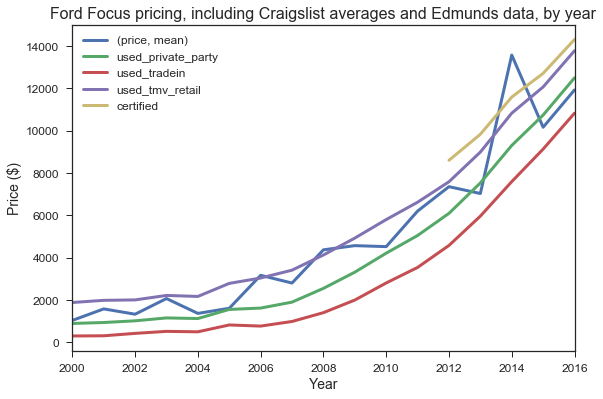

In [56]:
%matplotlib inline
focus_years = focus_years.replace(0, np.nan)
ax = focus_years.plot(y=[('price', 'mean'), 'used_private_party', 'used_tradein', 'used_tmv_retail', 'certified'], lw=3)
ax.set_ylabel("Price ($)", fontdict={'fontsize': 14})
ax.set_yticklabels(range(-2000,18000, 2000), fontdict={'fontsize': 12})
ax.set_xlabel("Year", fontdict={'fontsize': 14})
ax.set_xticklabels(range(2000,2018,2), fontdict={'fontsize': 12})
ax.set_title("Ford Focus pricing, including Craigslist averages and Edmunds data, by year", fontdict={'fontsize': 16})
ax.legend(fontsize = 'large')
fig=ax.get_figure()
fig.set_size_inches(9,6)
fig.savefig('compare_prices.pdf', bbox_inches='tight')

In [ ]:
focus_data[focus_data['year']==2016]

In [ ]:
focus_data[focus_data['year']==2014]

In [57]:
%store focus_data

Stored 'focus_data' (DataFrame)


In [58]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import ShuffleSplit, train_test_split

/Users/belinda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [100]:
data = all_car_info[['year', 'mileage', 'price']].dropna()
data = data[data['price'] < 100000]
data = data[data['price'] > 99]
data = data[data['mileage'] < 500000]
data = data[data['year'] > 1986]
X = data[['year', 'mileage']]
y = data['price']

In [182]:
coeff = []
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    coeff.append(model.coef_)
    scores.append(model.score(X_test,y_test))
print "Average score = {0} +/- {1}".format(round(np.mean(scores),3), round(np.std(scores),3))

Average score = 0.429 +/- 0.083


In [183]:
%store X_test
%store y_test
%store model
%store scores

Stored 'X_test' (DataFrame)
Stored 'y_test' (Series)
Stored 'model' (LinearRegression)
Stored 'scores' (list)


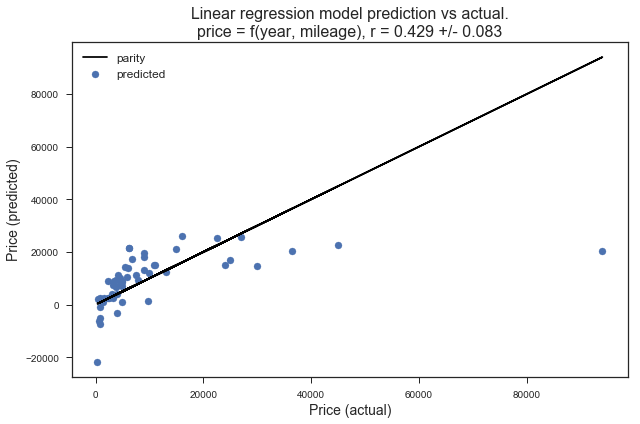

In [184]:
fig = plt.figure(figsize=(9,6))
plt.scatter(y_test, model.predict(X_test), label="predicted")
plt.plot(y_test, y_test, color='black', label="parity")
plt.title("Linear regression model prediction vs actual.\nprice = f(year, mileage), r = {0} +/- {1}".format(
    round(np.mean(scores),3), round(np.std(scores),3)), fontdict={'fontsize': 16})
plt.xlabel("Price (actual)", fontdict={'fontsize': 14})
plt.ylabel("Price (predicted)", fontdict={'fontsize': 14})
plt.legend(loc='best', fontsize='large')
plt.tight_layout()
fig.savefig('regression.pdf')

In [185]:
print model.coef_

[  6.00249077e+02  -1.31105790e-01]


Try and turn the plot into a Bokeh plot...

In [170]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Axis, HoverTool

In [186]:
radii = (X_test['year']-1986)/20 * 1500 # size of points is scaled to year

In [172]:
output_notebook()

Loading BokehJS ...

In [194]:
hover = HoverTool(tooltips=[('Predicted, Actual', '$x, $y')])
ax_limit = max(y_test + model.predict(X_test)) + 1000
p = figure(x_range=(0,ax_limit), y_range=(0,ax_limit), plot_width=500, plot_height=400, tools=[hover])
for axis in p.select(dict(type=Axis)):
    axis.formatter.use_scientific = False
p.circle(y_test, model.predict(X_test), radius = radii, line_color='black', fill_alpha=0.5)
p.line(y_test, y_test, color = 'gray')
show(p)